In [ ]:
##IMPORTS
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator 
from matplotlib.lines import Line2D 
import seaborn as sns
import pandas as pd

from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, mean_absolute_error,mean_squared_error 
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.decomposition import PCA
import os

In [ ]:
# import requests

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
os.chdir('/content/gdrive/MyDrive/ws-evaluating-improving-models')
os.listdir()


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


['evaluating-improving-models.ipynb',
 'dalle-tanks.png',
 'cross_validation_diagram.png',
 'nba_player_statistics.csv',
 'lantz_largerk.jpg',
 'training_testing_error.png',
 'sms_spam.csv']

In [ ]:
##TUTORIAL FUNCTIONS
def plot_decision_boundary(x, y, clf):
    
#     pca = PCA(n_components = 2)
#     x = pca.fit_transform(x)
#     knn = KNeighborsClassifier(n_neighbors=neighbors)
#     knn.fit(x, y)
#     clf=knn

    # create the x0, x1 feature
    x0 = x[:,0]
    x1 = x[:,1]

    PAD = 1.0 # how much to "pad" around the min/max values. helps in setting bounds of plot
    H = 0.1 # mesh stepsize
    PROB_DOT_SCALE = 40 # modifier to scale the probability dots
    PROB_DOT_SCALE_POWER = 3 # exponential used to increase/decrease size of prob dots
    TRUE_DOT_SIZE = 50 # size of the true labels

    x0_min, x0_max = np.round(x0.min())-PAD, np.round(x0.max()+PAD)
    x1_min, x1_max = np.round(x1.min())-PAD, np.round(x1.max()+PAD)

    x0_axis_range = np.arange(x0_min,x0_max, H)
    x1_axis_range = np.arange(x1_min,x1_max, H)

    xx0, xx1 = np.meshgrid(x0_axis_range, x1_axis_range)


    xx = np.reshape(np.stack((xx0.ravel(),xx1.ravel()),axis=1),(-1,2))
    # prediction of all the little dots
    yy_hat = clf.predict(xx) 

    # probability of each dot beingthe predicted color
    yy_prob = clf.predict_proba(xx) 

    # the size of each probability dot
    yy_size = np.max(yy_prob, axis=1)

    font = {'size'   : 10}

    plt.rc('font', **font)

    # make figure
    plt.style.use('seaborn-whitegrid') # set style because it looks nice
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18,10), dpi=150)

    # establish colors and colormap
    redish = '#d73027'
    orangeish = '#fc8d59'
    yellowish = '#fee090'
    blueish = '#4575b4'
    colormap = np.array([redish,blueish,orangeish])

    # plot all the little dots, position defined by the xx values, color
    # defined by the knn predictions (yy_hat), and size defined by the 
    # probability of that color (yy_prob)
    ax.scatter(xx[:,0], xx[:,1], c=colormap[yy_hat], alpha=0.4, 
               s=PROB_DOT_SCALE*yy_size**PROB_DOT_SCALE_POWER, linewidths=0,)

    # plot the contours
    ax.contour(x0_axis_range, x1_axis_range, 
               np.reshape(yy_hat,(xx0.shape[0],-1)), 
               levels=3, linewidths=1, 
               colors=[redish,blueish, blueish,orangeish,])

    # plot the original x values.
    # * zorder is 3 so that the dots appear above all the other dots 
    #color of the dots is determined by their actual label(i.e., y)
    ax.scatter(x[:,0], x[:,1], c=colormap[y], s=TRUE_DOT_SIZE, zorder=3, 
               linewidths=0.7, edgecolor='k')

    # create legends
    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()

    ax.set_ylabel("PC1")
    ax.set_xlabel("PC2")
    ax.set_title(f"Decision Boundary for $k$={clf.n_neighbors}")

    # create class legend
    legend_class = []
    for bball_positions, color in zip(['Center', 'Forward', 'Guard'], [blueish, redish, orangeish]):
        legend_class.append(Line2D([0], [0], marker='o', label=bball_positions,ls='None',
                                   markerfacecolor=color, markersize=np.sqrt(TRUE_DOT_SIZE), 
                                   markeredgecolor='k', markeredgewidth=0.7))

    # iterate over each of the probabilities to create prob legend
    prob_values = [0.4, 0.6, 0.8, 1.0]
    legend_prob = []
    for prob in prob_values:
        legend_prob.append(Line2D([0], [0], marker='o', label=prob, ls='None', alpha=0.8,
                                  markerfacecolor='grey', 
                                  markersize=np.sqrt(PROB_DOT_SCALE*prob**PROB_DOT_SCALE_POWER), 
                                  markeredgecolor='k', markeredgewidth=0))



    legend1 = ax.legend(handles=legend_class, loc='center', 
                        bbox_to_anchor=(1.15, 0.35),
                        frameon=False, title='class')

    legend2 = ax.legend(handles=legend_prob, loc='center', 
                        bbox_to_anchor=(1.15, 0.65),
                        frameon=False, title='prob', )

    ax.add_artist(legend1) # add legend back after it disappears

#     ax.set_yticks(np.arange(x1_min,x1_max, 1)) # I don't like the decimals
    ax.grid(False) # remove gridlines (inherited from 'seaborn-whitegrid' style)

    # only use integers for axis tick labels
    # from: https://stackoverflow.com/a/34880501/9214620
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))

    # remove first ticks from axis labels, for looks
    # from: https://stackoverflow.com/a/19503828/9214620
#     ax.set_xticks(ax.get_xticks()[1:-1])
#     ax.set_yticks(np.arange(x1_min,x1_max, 1)[1:])
    
    ax.set_aspect(1)

    plt.show()

## Introduction
 

In this workshop, I will give an introductory overview of evaluation metrics, paradigms, and pitfalls to help you to construct valid evaluation strategies. 

**Amy** add in section about what it means for a model to be good? Possibly add in some content about construct validity, face validity, etc. Proxy variables. Was there something about this in the alignment problem? Add in something about reliability and validity at the end? Add in as an appendix section?

Evaluations are intended to serve at least one and probably more of the following goals:



*   To provide a point estimate of a model's performance
*   To provide information about the variance around that point estimate
*   To find the best parameters for a given model
*   To determine which of several models (given particular parameters) is the best 

Below, we will cover an introduction to how to address each of these goals with evaluation strategies and will touch on some additional considerations about how to best construct an evaluation strategy.

## Part I: Metrics

### Classification Metrics
**Accuracy** is the number of correct predictions divided by the total number of predictions made

<br/><br/>

$$\text{Accuracy} = \frac{\text{# Correct Predictions}}{\text{Total # of Predictions}}$$

<br/><br/>

Imagine that we are trying to build a model to filter out spam email. The following data contains the text of email messages along with their actual type (i.e., label). "Ham" messages constitute real email messages whereas "spam" messages are, well, spam.  

In [ ]:
spam_ham = pd.read_csv("https://raw.githubusercontent.com/amywinecoff/ml-teaching/main/ws-2023/sms_spam.csv")
spam_ham = spam_ham[['type']]
spam_ham.head()

,type
0,ham
1,ham
2,ham
3,spam
4,spam


If we have a quick look at the type column, we can see that most messages are ham.

In [ ]:
counts_df = spam_ham [['type']].groupby(['type']).size().reset_index(name='outcome_counts')
counts_df

,type,outcome_counts
0,ham,4812
1,spam,747


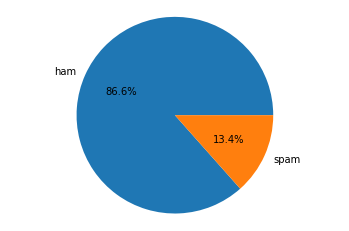

In [ ]:
fig1, ax1 = plt.subplots()
ax1.pie(counts_df['outcome_counts'], labels=counts_df['type'], autopct='%1.1f%%')
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

Using this data, we can build a very simple classifier, which just predicts the majority class. In other words, the classifier will always predict "ham."  

In [ ]:
dummy_clf = DummyClassifier(strategy="most_frequent")

#Note, by definition, the features are ignored in this model
dummy_clf.fit(np.zeros(spam_ham.size), spam_ham[['type']])
dummy_predictions = dummy_clf.predict(np.zeros(spam_ham.size))

accuracy = round(accuracy_score(spam_ham[['type']], dummy_predictions),3)
print(f'Accuracy of majority class model is: {accuracy}')

Accuracy of majority class model is: 0.866


Judging by overall accuracy alone, we might conclude that the dummy classifier is doing a decent job. But of course, this is is not a good model since it never predicts "spam," which is what we are actually trying to get the model to do correctly. Whenever we are thinking about designing an evaluation strategy, we have to consider what we actually care about. Just going with a defaul metric could work, or it could end up prioritizing an outcome during the training process at the expense of whatever you care about. As always, subject matter expertise is critical when developing a good machine learning pipeline at each stage of the development process from data collection/selection all the way through to evaluation. 

In our case, we are trying to develop a model that will allow us to detect and filter out spam. Therefore, we need to make sure our evaluation strategy makes sense for doing so even though it is the minority class. So, let's talk about some more granular strategies for assessing model performance.

A **confusion matrix** is used for classification models. It allows us to break down our results in terms of true positives, true negatives, false positives, and false negatives. This gives us a better sense of the kinds of errors our model is making.
<br/><br/>

|            | Predicted true | Predicted false |
|------------|----------------|-----------------|
|Actual true | True Positive  | False Negative  |
|Actual false| False Positive | True Negative   |

<br/><br/>

Accordingly, we can reframe our formula for accuracy as

$$\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}$$
<br/><br/>

We can create a confusion matrix from our majority class model

In [ ]:
cm = confusion_matrix(spam_ham[['type']], dummy_predictions)

#need to flip so spam is the positive case
cm = np.flip(cm)


cm_df = pd.DataFrame(cm, 
               columns=['predicted_spam', 'predicted_ham'], 
               index = ['actual_spam', 'actual_ham'])



cm_df

,predicted_spam,predicted_ham
actual_spam,0,747
actual_ham,0,4812


In this case, we'll consider "spam" the positive case since that is what we are trying to detect. So, cases where the model predicted "ham" but the message was actually "spam" are false negatives. We have 747 of these cases.

Because the dummy classifier always predicts "ham," there are no cases where the model predicted "spam" and the actual outcome was "ham;" however, if it had, those would constitute false positives.

Even though our model performed well in terms of overall accuracy, we can see from the confusion matrix that it performed abysmally in terms of false negatives. In machine learning, overall accuracy provides a poor measure of a model's performance when we have a "class imbalance," meaning one label occurs much more frequently than the other(s). 



Often with machine learning, we neither want a model that is too conservative in predicting the positive class nor too aggressive. Two metrics that help us assess this are precision and recall

<br/><br/>
**Precision** captures what proportion of the model's prediction of the positive class actually belong to the positive class. In other words, of all the times the model predicted the positive class, how often was that prediction correct? 

$$\text{Precision} = \frac{TP}{TP + FP}$$

<br/><br/>

**Recall** captures the proportion of cases that actually belong to the positive class were predicted as positive by the model. In other words, of all the actual positive cases, how many did we correctly predict?

$$\text{Recall} = \frac{TP}{TP + FN}$$


<br/><br/>
A precise model will only predict the positive class when the example is very likely to be positive. A model that has high recall will capture a large proportion of the actual positive examples. 

We will calculate precision and recall for our dummy classifier, but first we need to do some minor modifications on our predictions to make this possible. If we attempt to calculate these metrics from just the majority class predictions, we'll get into some divide by zero issues for precision since we have no spam predictions. 

I'll demonstrate this below, just to show you. 

In [ ]:
TP = cm_df.loc['actual_spam', 'predicted_spam']
TN = cm_df.loc['actual_ham', 'predicted_ham']
FP = cm_df.loc['actual_ham', 'predicted_spam']
FN = cm_df.loc['actual_spam', 'predicted_ham']

print (f'Precision is {TP/(TP + FP)}')
print (f'Recall is {TP/(TP + FN)}')

Precision is nan
Recall is 0.0


<ipython-input-11-3793712a4989>:6: RuntimeWarning: invalid value encountered in long_scalars
  print (f'Precision is {TP/(TP + FP)}')


Okay. For illustrative purposes, we'll add a few additional observations to our dataset that will allow us to calculate these metrics.

In [ ]:
new_data = pd.DataFrame(['spam', 'spam', 'spam', 'spam', 
                         'spam', 'spam', 'ham', 'ham'], columns=['type'])


new_predictions = np.array(['spam', 'spam', 'spam', 'spam', 
                                'spam', 'spam', 'spam', 'spam'])

new_spam_ham = pd.concat([spam_ham, new_data], ignore_index=True)
new_dummy_predictions = np.append(dummy_predictions, new_predictions)

new_cm = confusion_matrix(new_spam_ham[['type']], new_dummy_predictions)

#need to flip so spam is the positive case
new_cm = np.flip(new_cm)


new_cm_df = pd.DataFrame(new_cm, 
               columns=['predicted_spam', 'predicted_ham'], 
               index = ['actual_spam', 'actual_ham'])



new_cm_df


,predicted_spam,predicted_ham
actual_spam,6,747
actual_ham,2,4812


Our new confusion matrix reveals that we have 6 true positives, 4812 true negatives, 2 false positives, and 747 false negatives. With these, we can now calculate precision and recall.

In [ ]:
TP = new_cm_df.loc['actual_spam', 'predicted_spam']
TN = new_cm_df.loc['actual_ham', 'predicted_ham']
FP = new_cm_df.loc['actual_ham', 'predicted_spam']
FN = new_cm_df.loc['actual_spam', 'predicted_ham']

dc_precision = TP/(TP + FP)
dc_recall = TP/(TP + FN)

print (f'Precision is {dc_precision}')
print (f'Recall is {dc_recall}')


Precision is 0.75
Recall is 0.00796812749003984


Precision is better than recall. We just added 8 instances of the model "predicting" spam, with 6 of those being correct (6/8 = 0.75). So, the predictions are reasonably precise.

What our predictions do not do well is cover all the actual instances of spam in the dataset. This is captured in our recall measure, which is very low. Again, this is because our predictions do not capture (i.e., correctly predict) most of the actual spam examples.

Precision and recall can tell us a lot about how our model is performing, but it's nice to have a single summary statistic as well. The F1 Score combines precision and recall using the harmonic mean.

**F1 score** is the harmonic mean of precision and recall. 


$$\text{F}_1 = 2 \cdot \frac{\text{precision} \cdot \text{recall}}{\text{precision} + \text{recall}}$$

In [ ]:
dc_F1 = 2* ((dc_precision*dc_recall)/(dc_precision + dc_recall))
print(f'F1 is: {dc_F1}')

F1 is: 0.01576872536136662


Since the F1 score captures aspects of both precision and recall, the overall assessment reflects that this is not a good model.

Note, we can also calculate all these metrics using the metrics functionality of `scikit learn`.

In [ ]:
new_spam_ham['pos_case'] = np.where(new_spam_ham['type']== 'spam', 1, 0)
new_dummy_predictions_binary = np.where(new_dummy_predictions == 'spam', 1,0)
f1_score(new_spam_ham[['pos_case']], new_dummy_predictions_binary)


0.01576872536136662

There are many other metrics for evaluating classification models. Techniques that may be a particular help for visualizing results are precision recall curves or receiver operating characteristic (ROC) curves. [Applied Predictive Modeling](http://appliedpredictivemodeling.com/) by Kuhn & Johnson contains a good explanation of these methods.

### Regression Metrics

So far we have only discussed metrics for evaluating classification models, but of course, there are metrics for evaluating regression models as well. Several metrics that are commonly used include mean absolute error, mean squared error, and root mean squared error. In the formulas below, $y_i$ is the actual value for observation i and $\hat{y}_i$ is the predicted value for observation i. To illustrate, we'll mock up a quick linear regression and plot it.

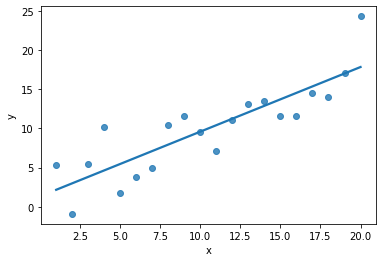

In [ ]:
x = np.arange(1,21)
noise = np.random.normal(0,3,len(x))
y = x + noise
df = pd.DataFrame.from_dict({'x': x, 'y': y})
sns.regplot(data=df, x='x', y='y', ci=None)
# plt.ylim(bottom=0)
# plt.xlim(left=0)
plt.show()

**Mean Absolute Error** (MAE) is the mean of the absolute value of the errors:

$$\frac 1n\sum_{i=1}^n|y_i-\hat{y}_i|$$
 
**Mean Squared Error** (MSE) is the mean of the squared errors:

$$\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2$$

**Root Mean Squared Error** (RMSE) is the square root of the mean of the squared errors:

$$\sqrt{\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2}$$





As with regression in the context of null hypothesis significance testing, we can see the residuals between the regression line and the actual data points. Because the errors could be in the positive or negative direction, we cannot simply use the difference between the data point and the regression line; we need a method for making all of the errors positive. Using the absolute value of the error as in mean absolute error (MAE) is one way to do this. Mean sqaured error (MSE) and root mean squared error (RMSE) are also ways of doing this. Several other regression metrics also exist, but for brevity, we will not discuss them here. As always, which metric you use should be informed by an understanding of the domain as well as your model choices.

## Evaluation Paradigms

In [ ]:
#Add in explanation of overfitting? https://www.quora.com/What-is-an-intuitive-explanation-of-over-fitting-particularly-with-a-small-sample-set-What-are-you-essentially-doing-by-over-fitting-How-does-the-over-promise-of-a-high-R%C2%B2-low-standard-error-occur/answer/Jessica-Su

Thus far, we have discussed evaluation without diving into which data our metrics are calculated on. In machine learning, we train a model on one dataset with the goal of making accurate predictions in another dataset. In other words, we aim to create a model that has good generalization. Our evaluation metrics should ideally give us a good sense of how well our model would perform on new data. We will explore several different strategies for training and evaluating models that have different implications for generalization (some good and some not so good).

First, let's load some new data. 


In [ ]:
nba = pd.read_csv("https://raw.githubusercontent.com/amywinecoff/ml-teaching/main/ws-2023/nba_player_statistics.csv")
nba.head()

,ast,stl,blk,tov,pf,pts,name,position,team
0,1.941176,0.917647,0.229412,1.088235,2.023529,11.088235,Wesley Matthews,SG,LAL
1,1.133333,0.233333,0.050000,0.516667,0.950000,2.650000,Justin Robinson,PG,OKC
2,1.071429,0.414286,0.128571,0.500000,1.171429,5.057143,Rodney McGruder,SG,DET
3,0.200000,0.172727,0.072727,0.327273,0.990909,1.554545,Anthony Gill,PF,WAS
4,0.825000,0.300000,0.850000,0.600000,1.800000,4.725000,Goga Bitadze,C,IND


The data we will be using for the next section of the workshop contains statistics for NBA players, drawn from www.basketball-reference.com, albeit in modified form. The data reflects players' per-season averages for several key metrics. As an example, if a player averaged 10 points per game in their first season, and 20 points per game in their second season, their per-season average points per game is 15. 

The per-season average statistics we will be using are the following:

* **AST** - Assists
* **BLK** - Blocks
* **PF** - Personal Fouls
* **PTS** - Points
* **STL** - Steals
* **TOV** - Turnovers

Using these statistics, we will use KNN classification to predict players' positions. We already provided an introduction to the KNN algorithm in the first day of the Introduction to ML Series, but as a quick refresher, the overarching idea in KNN is that for each example we want to classify, we take the *k* examples whose features are most similar to the new example, and apply whatever label the majority of them have. To determine which examples are most similar, we calculate the distance between the example we are trying to classify and all other examples in our dataset. We often use the Euclidean distance for this, though some other distances are sometimes used. The following formula captures the Euclidean distance for two points *p* and *q*:

$$d\left( p,q\right)   = \sqrt {\sum _{i=1}^{n}  \left( q_{i}-p_{i}\right)^2 }$$

The data from www.basketball-reference.com classifies players positions as point guard (PG), shooting guard (SG), power forward (PF), small forward (SF), and center (C). For simplicity, we will collapse those into three categories: guards, forwards, and centers. We'll map those to numeric values in our dataset such that centers=0, forwards=1, and guards=2. 

In [ ]:
# map positions to numbers
nba['pos_num'] = nba.position.map({'C':0, 'SF':1, 'PF':1, 'SG':2, 'PG':2})

To create the model, we'll be using the `scikit-learn` library. To train a model, we'll need to separate out our feature columns (i.e., the basketball stats) from our labels (i.e., the player's position).

In [ ]:
#create feature data set
X = nba[['ast', 'stl', 'blk', 'tov', 'pf', 'pts']]

# create response vector (y)
y = nba.pos_num

Let's take a look at the number of players that fall into each position category:

In [ ]:
count_df = nba[['pos_num']].groupby(['pos_num']).size().reset_index(name='outcome_counts')
#count_df['proportion'] = count_df['outcome_counts']/sum(count_df['outcome_counts'])
count_df.head()

,pos_num,outcome_counts
0,0,82
1,1,171
2,2,194


In [ ]:
fig1, ax1 = plt.subplots()
ax1.pie(count_df['outcome_counts'], labels=count_df['pos_num'], autopct='%1.1f%%')
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

#Reminder: centers=0, forwards=1, and guards=2
plt.show()

As with the spam and ham data we started with, we have a class imbalance in our labels. It is not nearly as severe, but still worth bearing in mind as we calculate our model performance metrics. Note that the metrics we walked through earlier, in their most basic implementation, deal with binary classification tasks. These measures are slightly more complicated for multi-class classification, but it is still possible to calculate them. For brevity, we will not go into that here, but you can check out the `scikit-learn` [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) on this to learn more

Before we begin fitting our model, we need transform our features so that they exist on the same scale. Why is this the case? Well, first, let's have a quick look at the data:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1e3e44cfa0>,
      dtype=object)

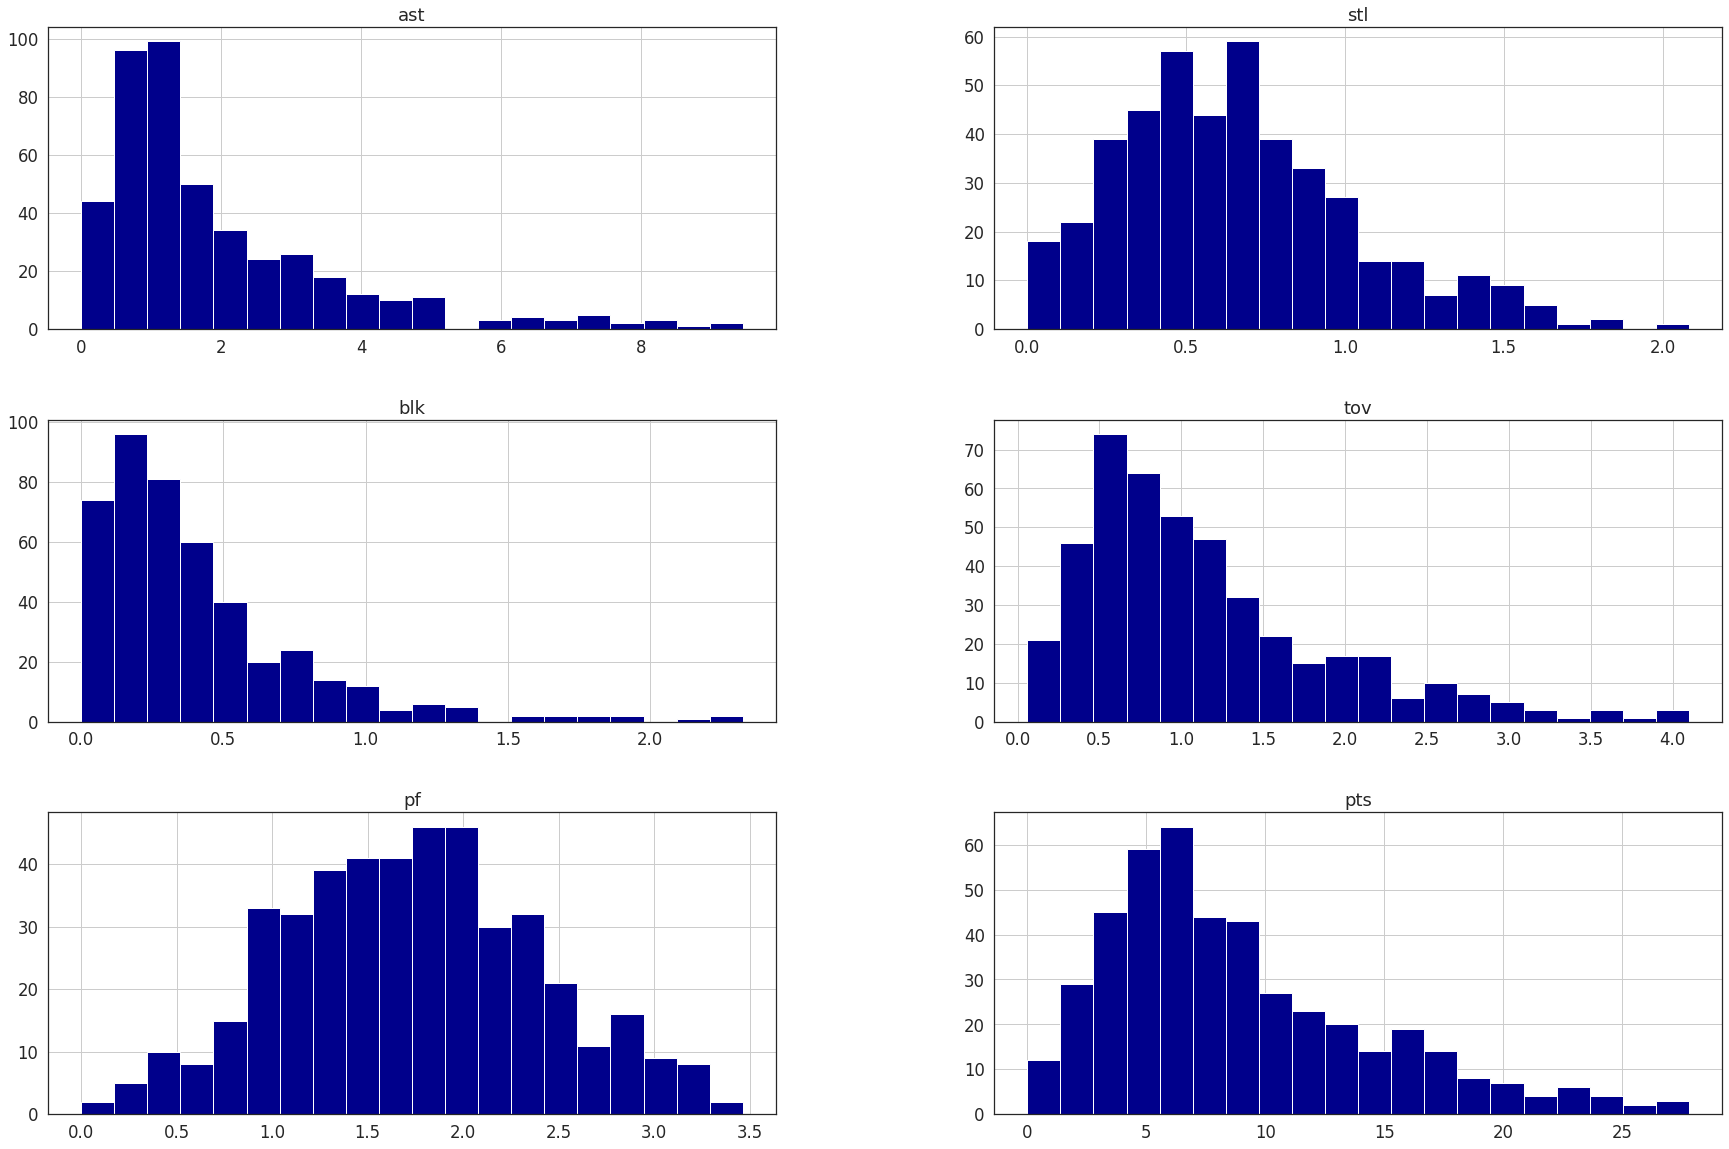

In [ ]:
# feature plotting
sns.set(style='white',font_scale=1.5, rc={'figure.figsize':(30,20)})
X.hist(bins=20,color='darkblue' )

The range of some of the features is much larger than others. When we're using KNN, we classify examples using their distance to other examples. If some features have a much large range than others, they will tend to dominate this distance calculation, minimizing the impact of features with smaller ranges. For our algorithm, we'll make use of the `StandardScaler` class in `scikit-learn`, and it's default scaling method, which is [z-scoring](https://en.wikipedia.org/wiki/Standard_score). Note that in the cell below, scaling has been performed across all of our input data. This is not advisable, but I will come back to that in a bit. 

In [ ]:
scaler = StandardScaler()
scaler.fit(X)
X_scale = scaler.transform(X)

### Train on all the data

One method for fitting and evaluating models would be to develop a model that is maximally accurate on our entire dataset and report the accuracy as calculated on all the data. This is akin to doing the following:

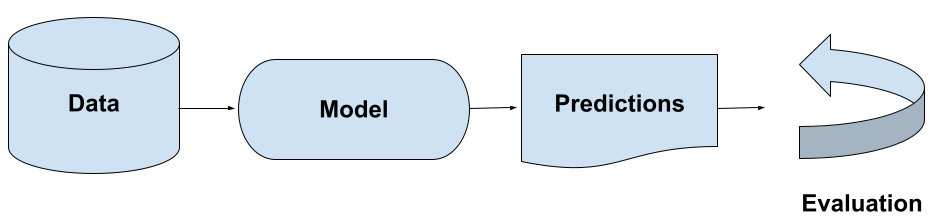

This is known as training accuracy because we are evaluating the model on the same data we used to train the model. Note that there is an arrow at the evaluation stage. This is because we often change our model or aspects of our data in response to the evaluation metrics we achieve.

Let's look at an example of this process. We'll start with a model that uses the top 10 nearest neighbors to classify each example using all the training data for the entire process.

In [ ]:
# instantiate the model
knn = KNeighborsClassifier(n_neighbors=10)

# train the model on the entire dataset
knn.fit(X_scale, y)

# store the predicted response values
y_pred_class = knn.predict(X_scale)

print (accuracy_score(y, y_pred_class))

0.7404921700223713


In terms of overall training accuracy, this is a decent model. But can we make it even better? Let's try with a smaller k...


In [ ]:
# instantiate the model
knn = KNeighborsClassifier(n_neighbors=5)

# train the model on the entire dataset
knn.fit(X_scale, y)

# store the predicted response values
y_pred_class = knn.predict(X_scale)

print (accuracy_score(y, y_pred_class))

0.7829977628635347


And an EVEN SMALLER k...

In [ ]:
# instantiate the model
knn = KNeighborsClassifier(n_neighbors=1)

# train the model on the entire dataset
knn.fit(X_scale, y)

# store the predicted response values
y_pred_class = knn.predict(X_scale)

print (accuracy_score(y, y_pred_class))

1.0


We have obtained PERFECT accuracy. Yay! Just kidding, this isn't actually a good thing. Intuitively, it probably makes sense to you that this is an unrealistically optimistic estimate of our model's future performance. In the case of *k*=1, the model is able to obtain perfect accuracy because when we use every example to fit the model, the nearest neighbor to every example is itself:

$$d(p,p)=0$$


In [ ]:
neigh_dist, neigh_ind = knn.kneighbors(X_scale, 1)
for i in range(6):
    print(f'Index of nearest neighbor for example {i} is {neigh_ind[i]}')

Index of nearest neighbor for example 0 is [0]
Index of nearest neighbor for example 1 is [1]
Index of nearest neighbor for example 2 is [2]
Index of nearest neighbor for example 3 is [3]
Index of nearest neighbor for example 4 is [4]
Index of nearest neighbor for example 5 is [5]


By fitting our model on all our data and evaluating performance on this same dataset, we have created a model that captures our training data perfectly, but is unlikely to generalize to new data. To provide a visualization of this, we'll use a decision boundary plot. This kind of plot allows us to look at how the model makes decisions about which class to predict. 
<!-- https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html -->

Because we have more than two features, we will use PCA to collapse our feature data into two dimensions for visualization purposes.

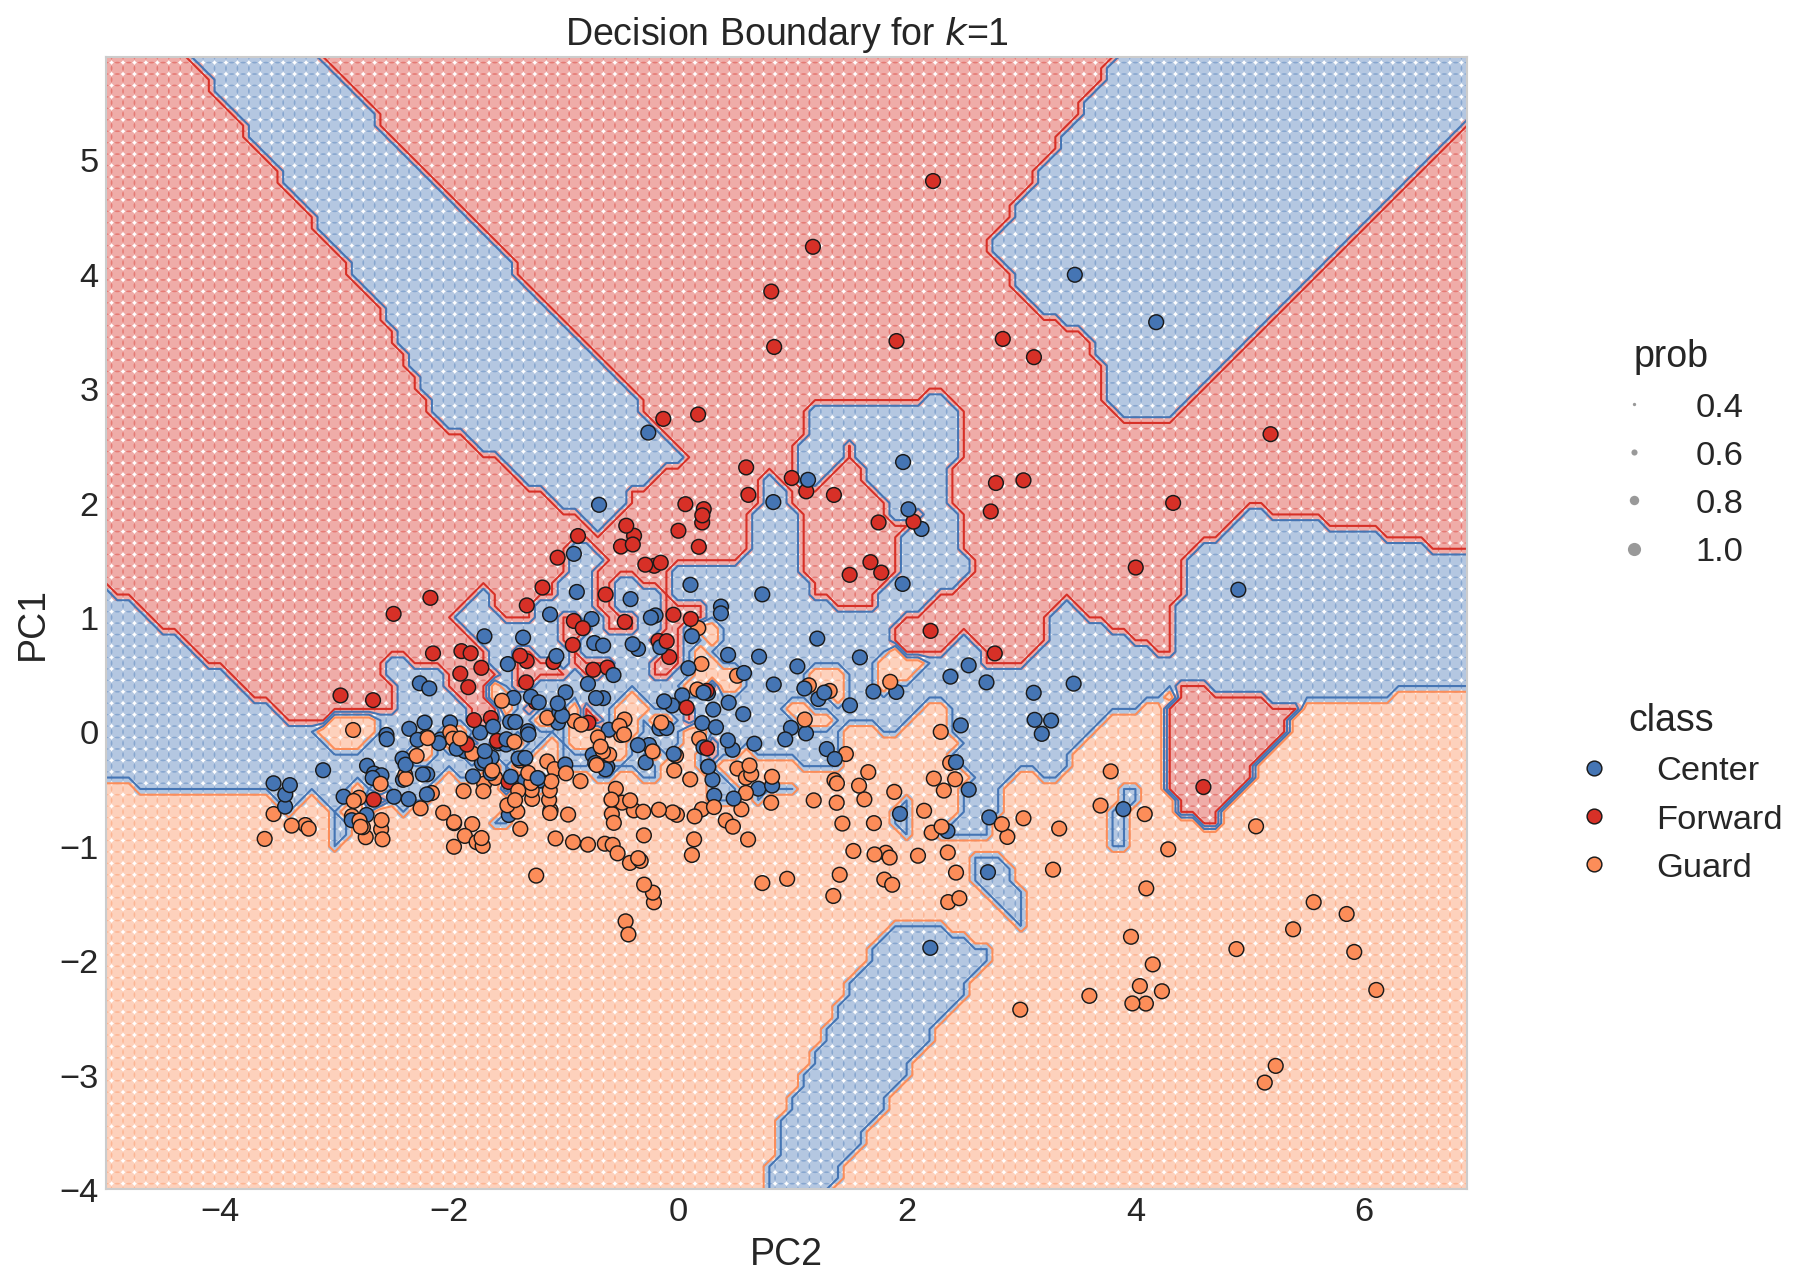

In [ ]:
pca = PCA(n_components = 2)
x = pca.fit_transform(X_scale)
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(x, y)


plot_decision_boundary(x, y, knn)

This plot looks pretty ridiculous. Although it fits our training data perfectly (because each example was predicted using itself), it is unlikely that new examples that were not in our training data are likely to fit this same pattern exactly.

Thus, we need a better way to estimate the out-of-sample performance of our model, both so that we have a (more) realistic estimate of how our model will perform and so that we can choose a reasonable value for *k*. 

### Train/Test Splits
One alternative approach is to partition your dataset into two subsets. You train your model on one subset (ie., the training set) and evaluate your model in the other (i.e., the test set). The model's performance on the test set is referred to as the **testing accuracy** because we are evaluating the model on an (in theory) independent dataset that was not used during model training. For this reason, testing accuracy is usually a better estimate of out-of-sample performance than training accuracy. 



This is akin to the following process: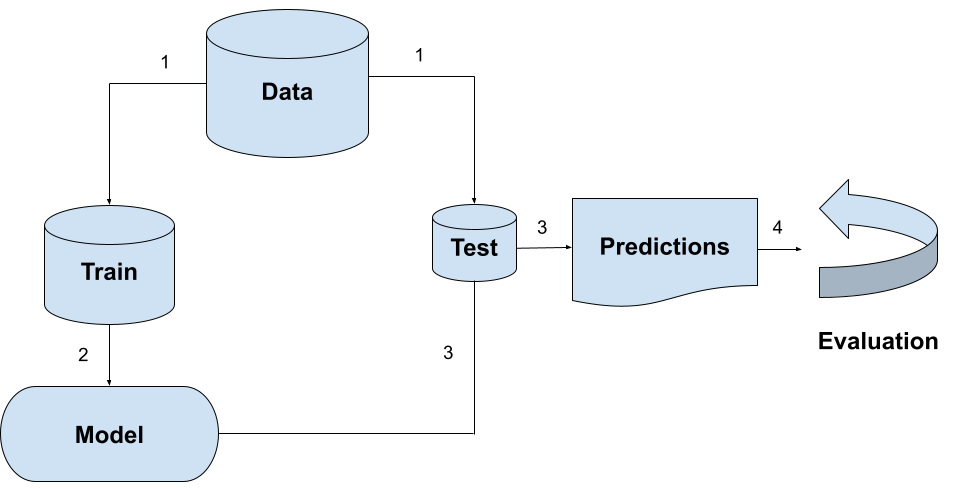

We can use the built-in functionality in `scikit-learn` to split our data into training and testing sets. Note that in the code below, we **do not** run our scaler on the entire dataset and then split it, but rather, we first split the data, fit the scaler to the training data, then apply it to the train and test sets.

In [ ]:
# STEP 1: split X and y into training and testing sets (using random_state for reproducibility)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=98, test_size=0.20)

# STEP 2: Create a scaler, fit to the TRAINING data and apply to train and test
scaler = StandardScaler()
# # Fit only on X_train
scaler.fit(X_train)

# # Scale both X_train and X_test
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# STEP 3: train the model on the training set (using K=1)
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

# STEP 4: test the model on the testing set, and check the accuracy
y_pred_class = knn.predict(X_test)
print (f'accuracy is {accuracy_score(y_test, y_pred_class)}')

# compute null accuracy
print(f'null accuracy is {y_test.value_counts().head(1) / len(y_test)}')


accuracy is 0.5333333333333333
null accuracy is 1    0.444444
Name: pos_num, dtype: float64


So, when we use only the single nearest neighbor in the training set to predict the class in the test set, the model performs pretty poorly, espectially when we look at what the null accuracy, the accuracy we could achieve by just predicting the majority class. Let's have a look at what it looks like when we make predictions in the test set based only on each test data point's single closest neighbor in the training set. 

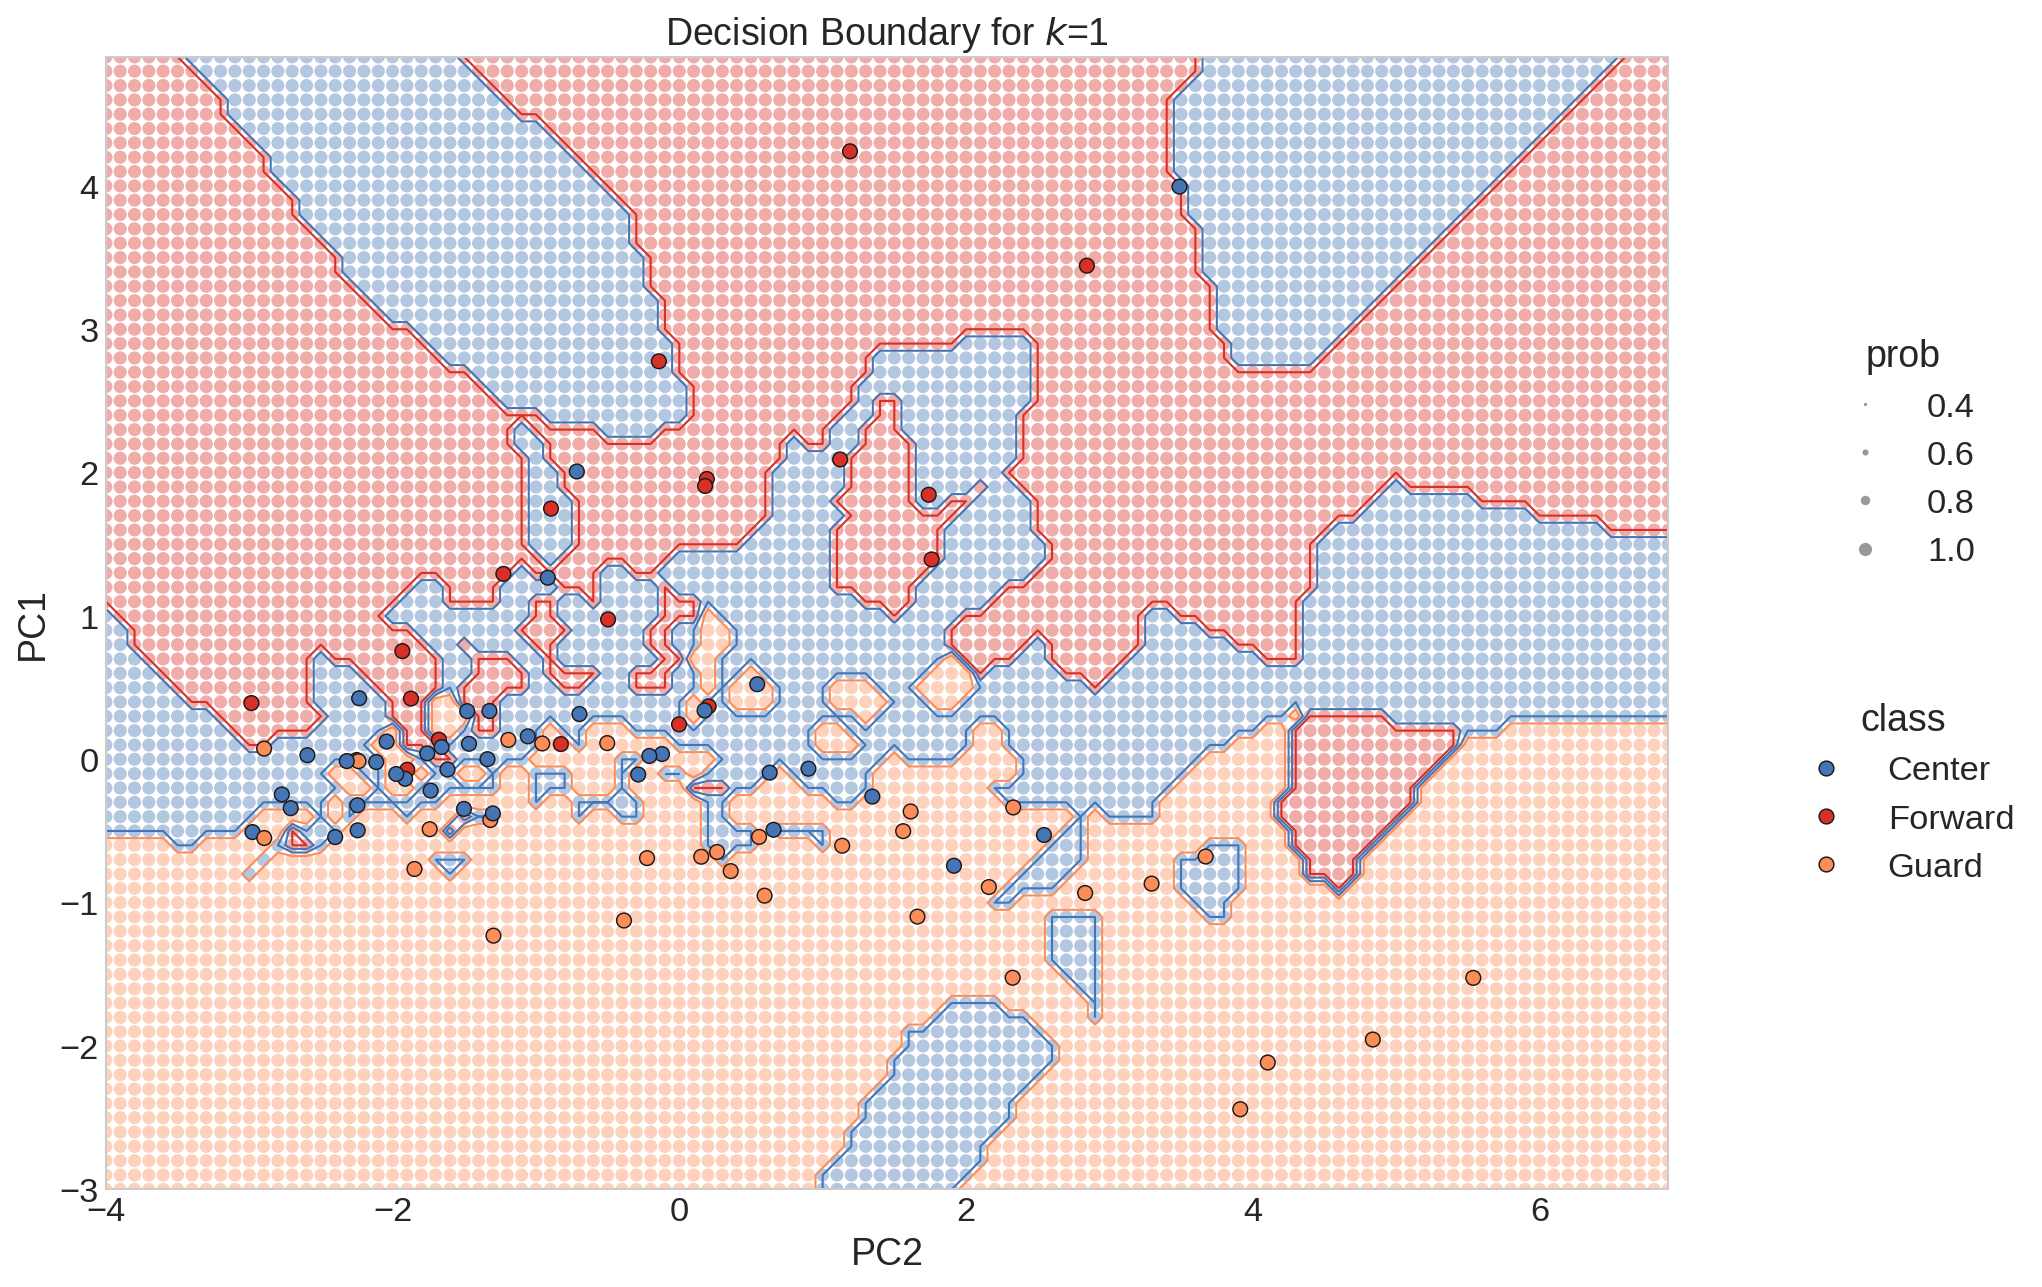

In [ ]:
# STEP 1: split X and y into training and testing sets (using random_state for reproducibility)
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=98, test_size=0.20)

# # STEP 2: Create a scaler, fit to the TRAINING data and apply to train and test
# scaler = StandardScaler()
# # # Fit only on X_train
# scaler.fit(X_train)

# # # Scale both X_train and X_test
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)


pca = PCA(n_components = 2)
pca.fit(X_train)

X_train = pca.transform(X_train)

X_test = pca.transform(X_test)
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

plot_decision_boundary(X_test, y_test, knn)

Not nearly so good. And, in a lot of those places where the decision boundary is very tailored, the model made a mistake predicting the outcome. This demostrates one form of what we refer to as "overfitting," when we create a model that performs very well on one dataset, but is unlikely to generalize to the actual scenario we care about (See also [this post](https://www.quora.com/What-is-an-intuitive-explanation-of-over-fitting-particularly-with-a-small-sample-set-What-are-you-essentially-doing-by-over-fitting-How-does-the-over-promise-of-a-high-R%C2%B2-low-standard-error-occur/answer/Jessica-Su) for an explanation of overfitting)

So, how do you know what value of k to select? Glad you asked. First, we'll do the following. We will fit$^1$ then model with a range of k values (1 to 50) on the training data, then evaluate performance in the test set using the k nearest neighbors in the training set. For illustrative purposes, we will also evaluate performance on the training data.

[1] I'll briefly mention why fitting is a bit of a weird term to use in the case of "lazy learners" like KNN during the workshop.

In [1]:
k_range = range(1, 51)
training_error = []
testing_error = []

for k in k_range:

    # instantiate the model with the current K value
    knn = KNeighborsClassifier(n_neighbors=k)

    # calculate training error
    knn.fit(X_train, y_train)
    y_pred_class = knn.predict(X_train)
    training_accuracy = accuracy_score(y_train, y_pred_class)
    training_error.append(1 - training_accuracy)
    
    # calculate testing error
    knn.fit(X_train, y_train)
    y_pred_class = knn.predict(X_test)
    testing_accuracy = accuracy_score(y_test, y_pred_class)
    testing_error.append(1 - testing_accuracy)


NameError: ignored

In [ ]:
# create a DataFrame of K, training error, and testing error
column_dict = {'K': k_range, 'training error':training_error, 'testing error':testing_error}
df = pd.DataFrame(column_dict).set_index('K').sort_index(ascending=False)
#df.head()

NameError: ignored

First, we will plot only the test error.

Text(0, 0.5, 'Error (lower is better)')

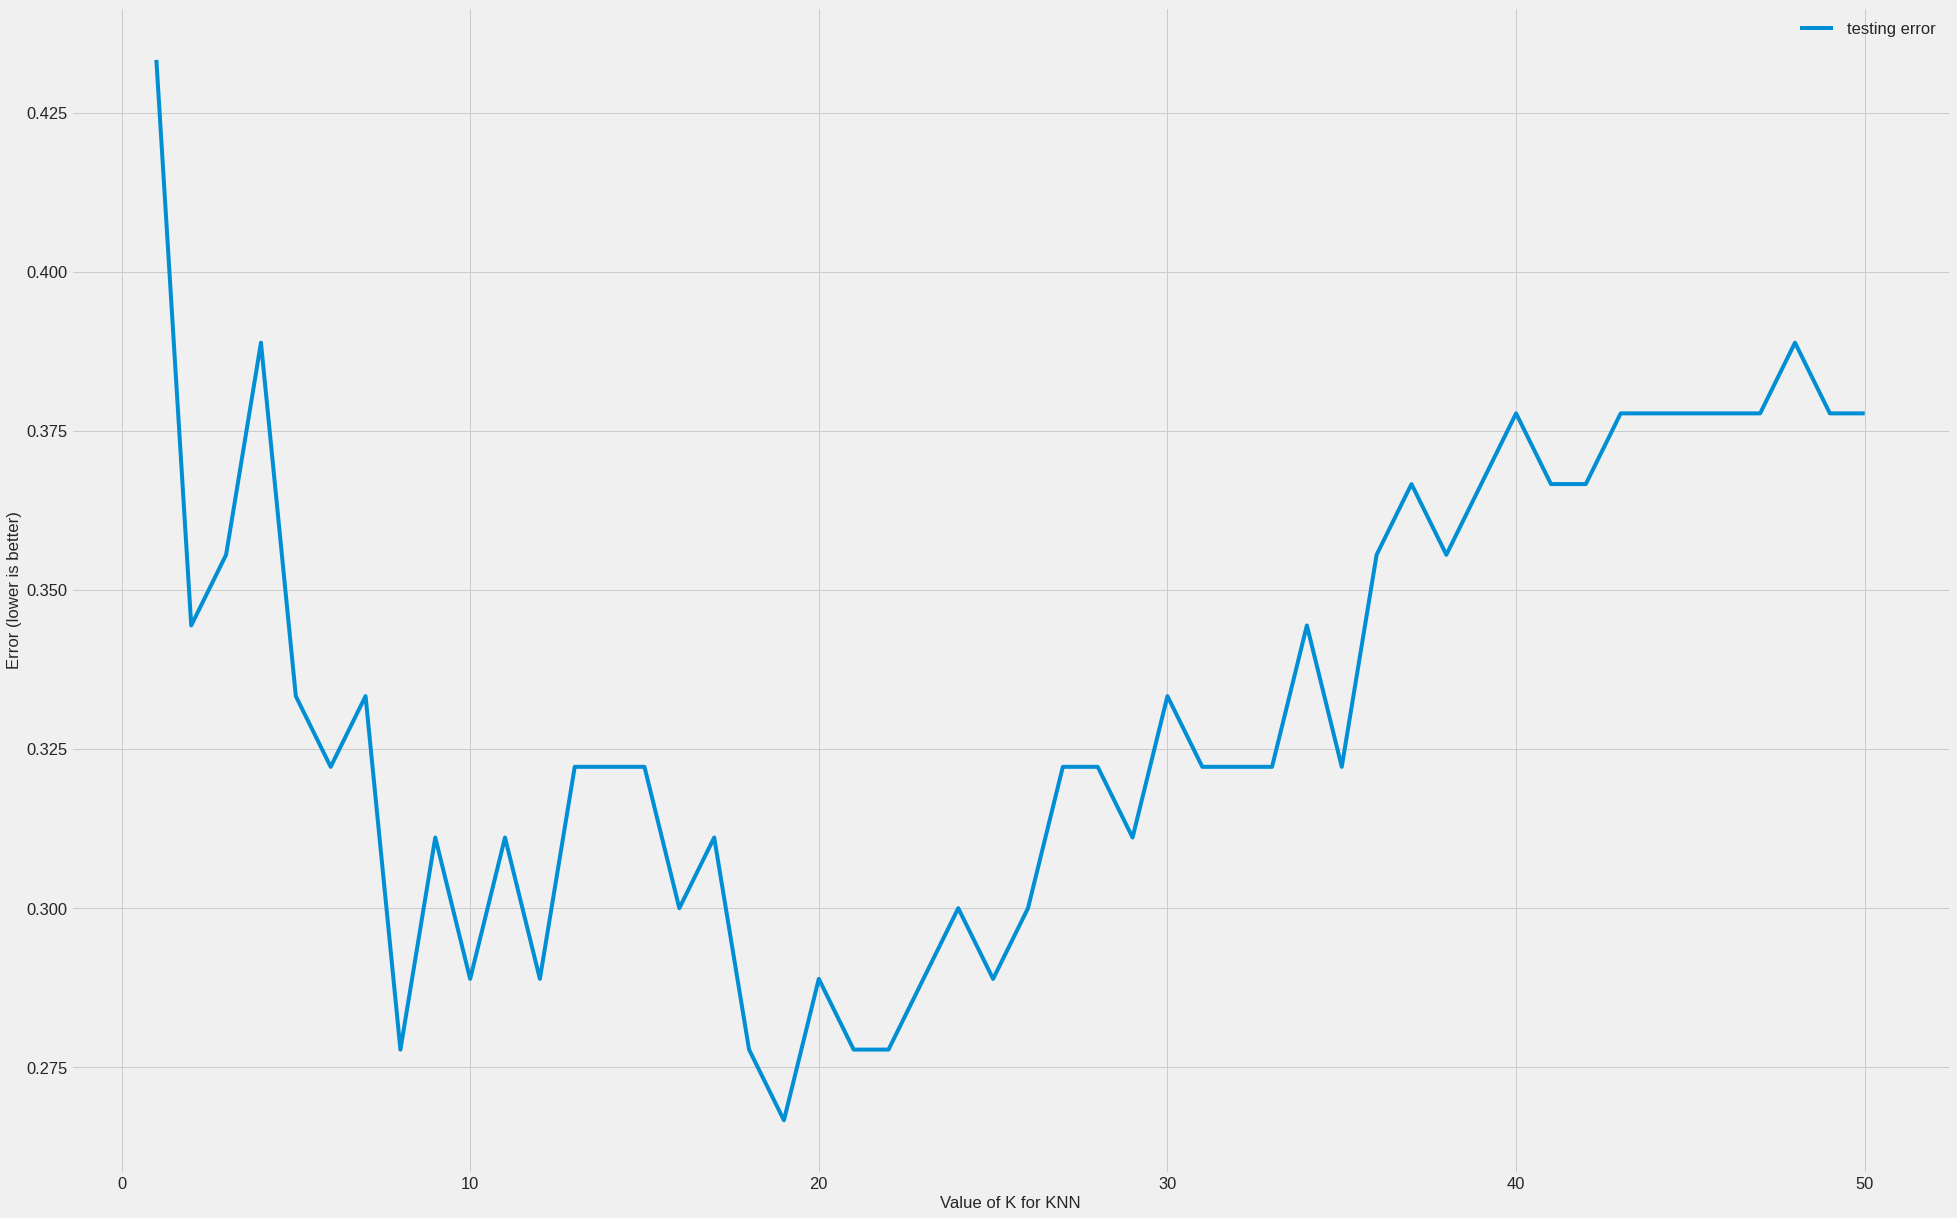

In [ ]:
# plot the relationship between K (HIGH TO LOW) and TESTING ERROR
df=df.sort_index(ascending=True)
df.head()
df.plot(y='testing error')
plt.xlabel('Value of K for KNN')
plt.ylabel('Error (lower is better)')

We can see from the plot that the error (generally) decreases as we increase k to a point, then begins to increase again.

In [ ]:
# find the minimum testing error and the associated K value
df.sort_values('testing error', ascending=True).head()

,training error,testing error
K,,
19,0.291317,0.266667
22,0.280112,0.277778
21,0.280112,0.277778
18,0.280112,0.277778
8,0.252101,0.277778


In [ ]:
1-0.266667

0.733333

When using KNN on this dataset with these features, the best value for K is likely to be somewhere near 20.
Given the statistics of an unknown player, we estimate that we would be able to correctly predict his position about 73% of the time. How would this compare if we looked only at performance on the training data? Let's have a look.

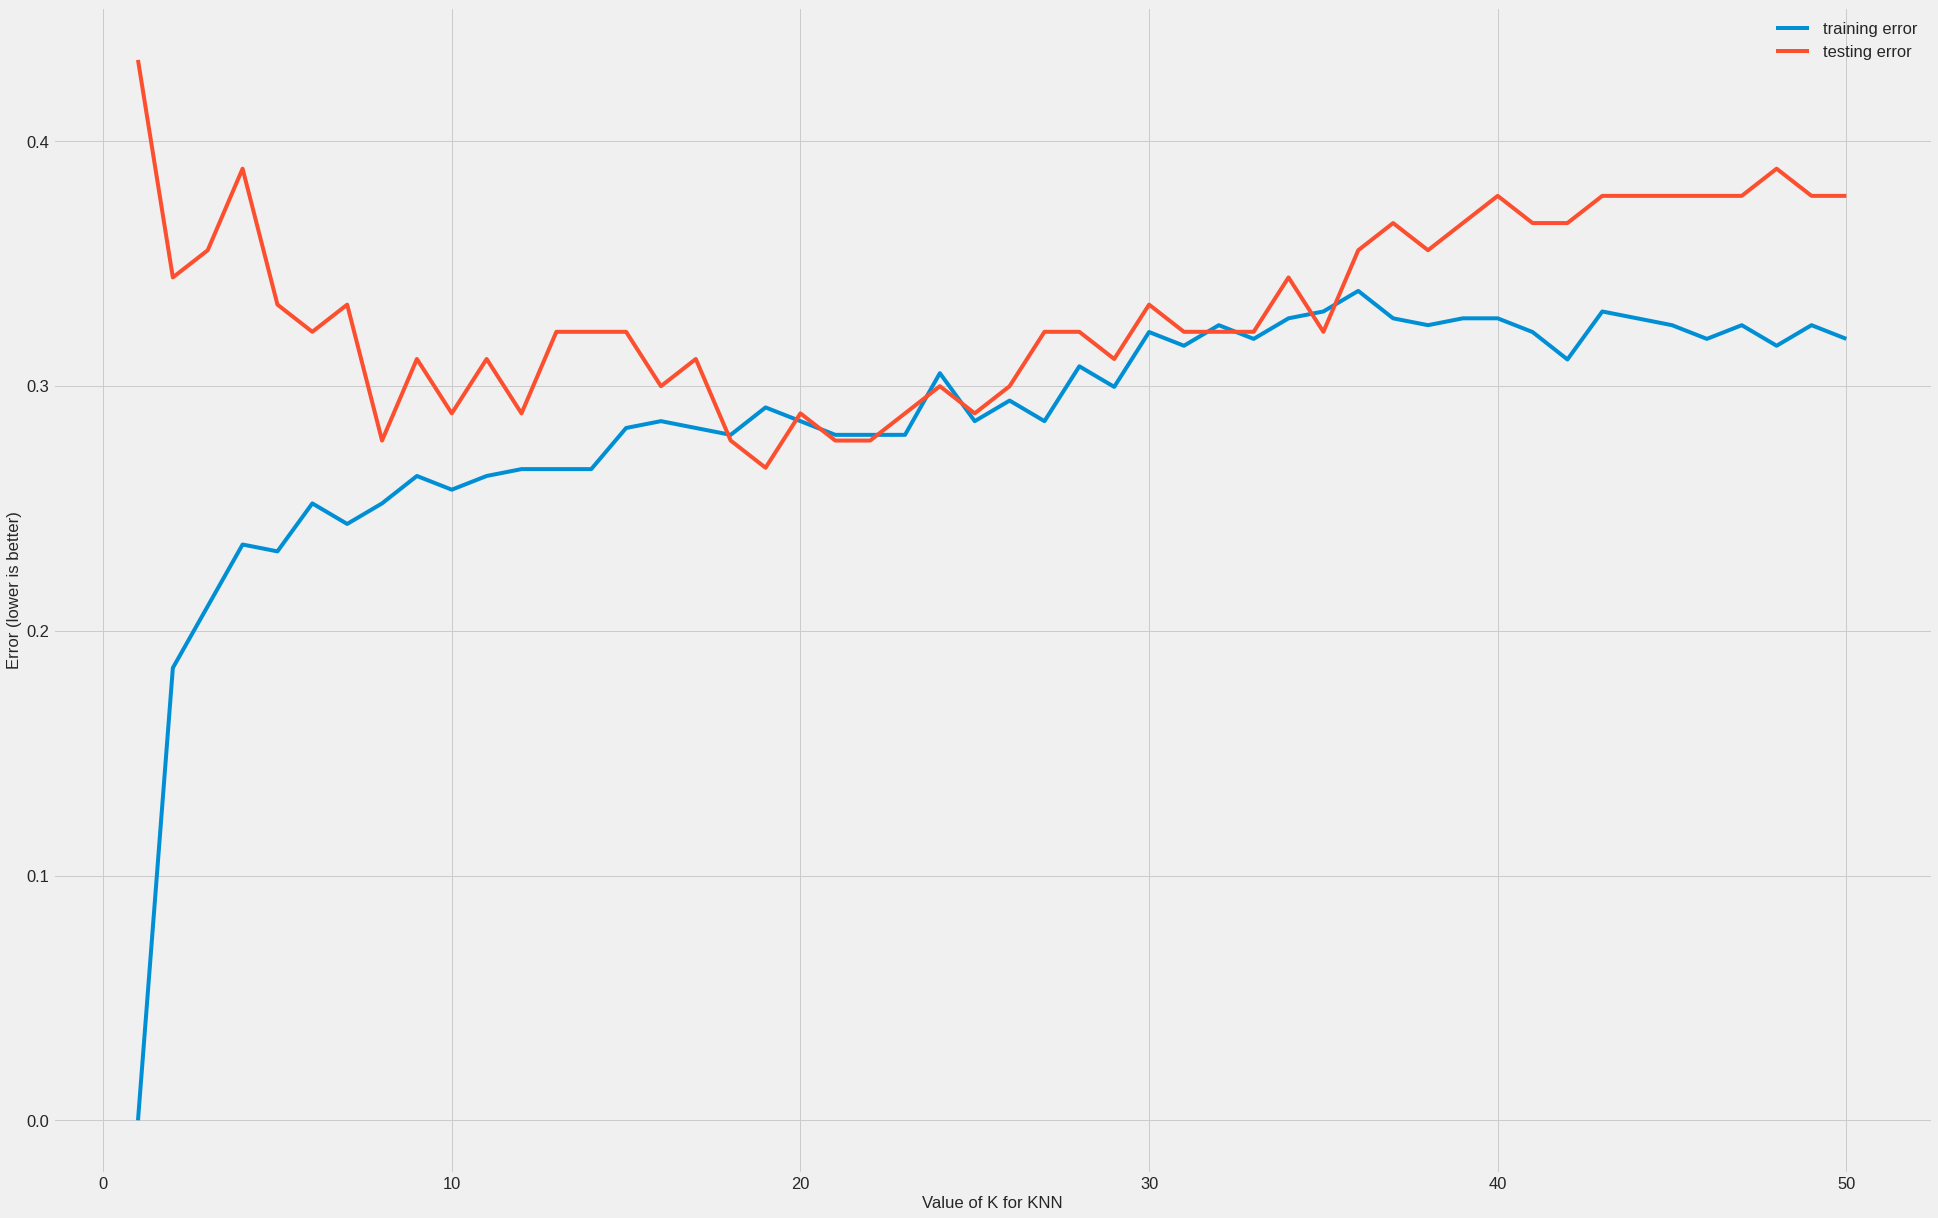

In [ ]:
# plot the relationship between K (from k=50 to k=1) and both training and testing error
df.plot()
#plt.gca().invert_xaxis()
plt.xlabel('Value of K for KNN')
plt.ylabel('Error (lower is better)')
plt.show()

We can see from the plot that as k approaches zero, the error on the training dataset continues to decrease whereas it begins to increase on the test data. 

So, we've shown that splitting the data into a training set and a testing set will yield a model that generalizes better than if we trained and tested on the same data. But this approach still has disadvantages. The performance estimates are still based on a single possible split of our data. What would happen if the `train_test_split` function had split the data differently? Would we get the same exact results as before? We'll try this by using a different random seed than the one we started with.

In [ ]:
# try different values for random_state
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=96, test_size=0.20)
# STEP 2: Create a scaler, fit to the TRAINING data and apply to train and test
scaler = StandardScaler()
# # Fit only on X_train
scaler.fit(X_train)

# # Scale both X_train and X_test
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=19)
knn.fit(X_train, y_train)
y_pred_class = knn.predict(X_test)
print (accuracy_score(y_test, y_pred_class))

0.6222222222222222


As you probably would have guessed, our model estimate is not the same with a different random seed. Train/test split is useful because of its flexibility and speed, but testing accuracy is a high-variance estimate of out-of-sample accuracy. K-fold cross-validation overcomes this limitation and provides more reliable estimates. Note that in the examples below, we will use all the data we have to perform cross validation, but this is usually not ideal (at least for academic projects) for reasons we will discuss later.

### K-fold cross validation

#### Steps for K-fold cross-validation
1. Split the dataset into K equal partitions (or "folds").
2. Use fold 1 as the testing set and the union of the other folds as the training set. 
3. Calculate testing accuracy.
4. Repeat steps 2 and 3 K times, using a different fold as the testing set each time.
5. Use the average testing accuracy as the estimate of out-of-sample accuracy.

**Diagram of 5-fold cross-validation:**

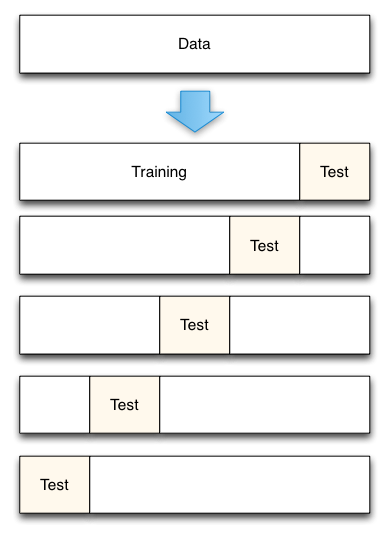!

In [ ]:
knn = KNeighborsClassifier(n_neighbors=12)
scores = cross_val_score(knn, X_scale, y, cv=5)
print(f"accuracy scores per fold are {np.round(scores,3)}. Average accuracy: {round(scores.mean(),3)}")

accuracy scores per fold are [0.744 0.756 0.629 0.64  0.663]. Average accuracy: 0.687


By using k-fold cross validation, we get a better sense of what we might expect the average model performance to be, given a training and testing dataset of the size we used in the procedure. While the number of estimates we have is small, we also do get some sense of the variance of performance estimates.

### Comparing cross-validation to train/test split

**Advantages of cross-validation:**

* More accurate estimate of out-of-sample accuracy
* More "efficient" use of data (every observation is used for both training and testing)

**Advantages of train/test split:**

* Runs K times faster than K-fold cross-validation
* Simpler to examine the detailed results of the testing process


**Cross-validation recommendations**
* K can be any number, but K=10 is generally recommended provided you have a reasonable amount of data
* For classification problems, stratified sampling (i.e., each set contains approximately the same percentage of samples of each target class as the complete set) is recommended for creating the folds. Depending on your model and which function you are using, `scikit-learn` may do this by default. Be sure to consult the documentation to double check. 
* Use nested cross validation (details below)

### Cross-validation for parameter tuning

**Goal**: Select the best tuning parameters (AKA "hyperparameters") for a model. In many machine learning models, multiple parameters must be set. Cross-validation can be used to determine what value to use for the parameter (or set of parameters). In our case, the parameter we are trying to find the best value for is k. This is conceptually similar to what we did using the train/test split method in which we computed the accuracy on the test set using different values of k. Here, we will get a more reliable estimate of the performance across values of k since we will be testing on more than one dataset.


In [ ]:
# search for an optimal value of K for KNN
k_range = range(1, 31)
k_scores = []
k_min = []
k_max = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_scale, y, cv=5, scoring='accuracy')
    k_scores.append(scores.mean())
    k_min.append(scores.min())
    k_max.append(scores.max())


Text(0.5, 1.0, 'Mean and Range of Accuracy from Cross-Validation')

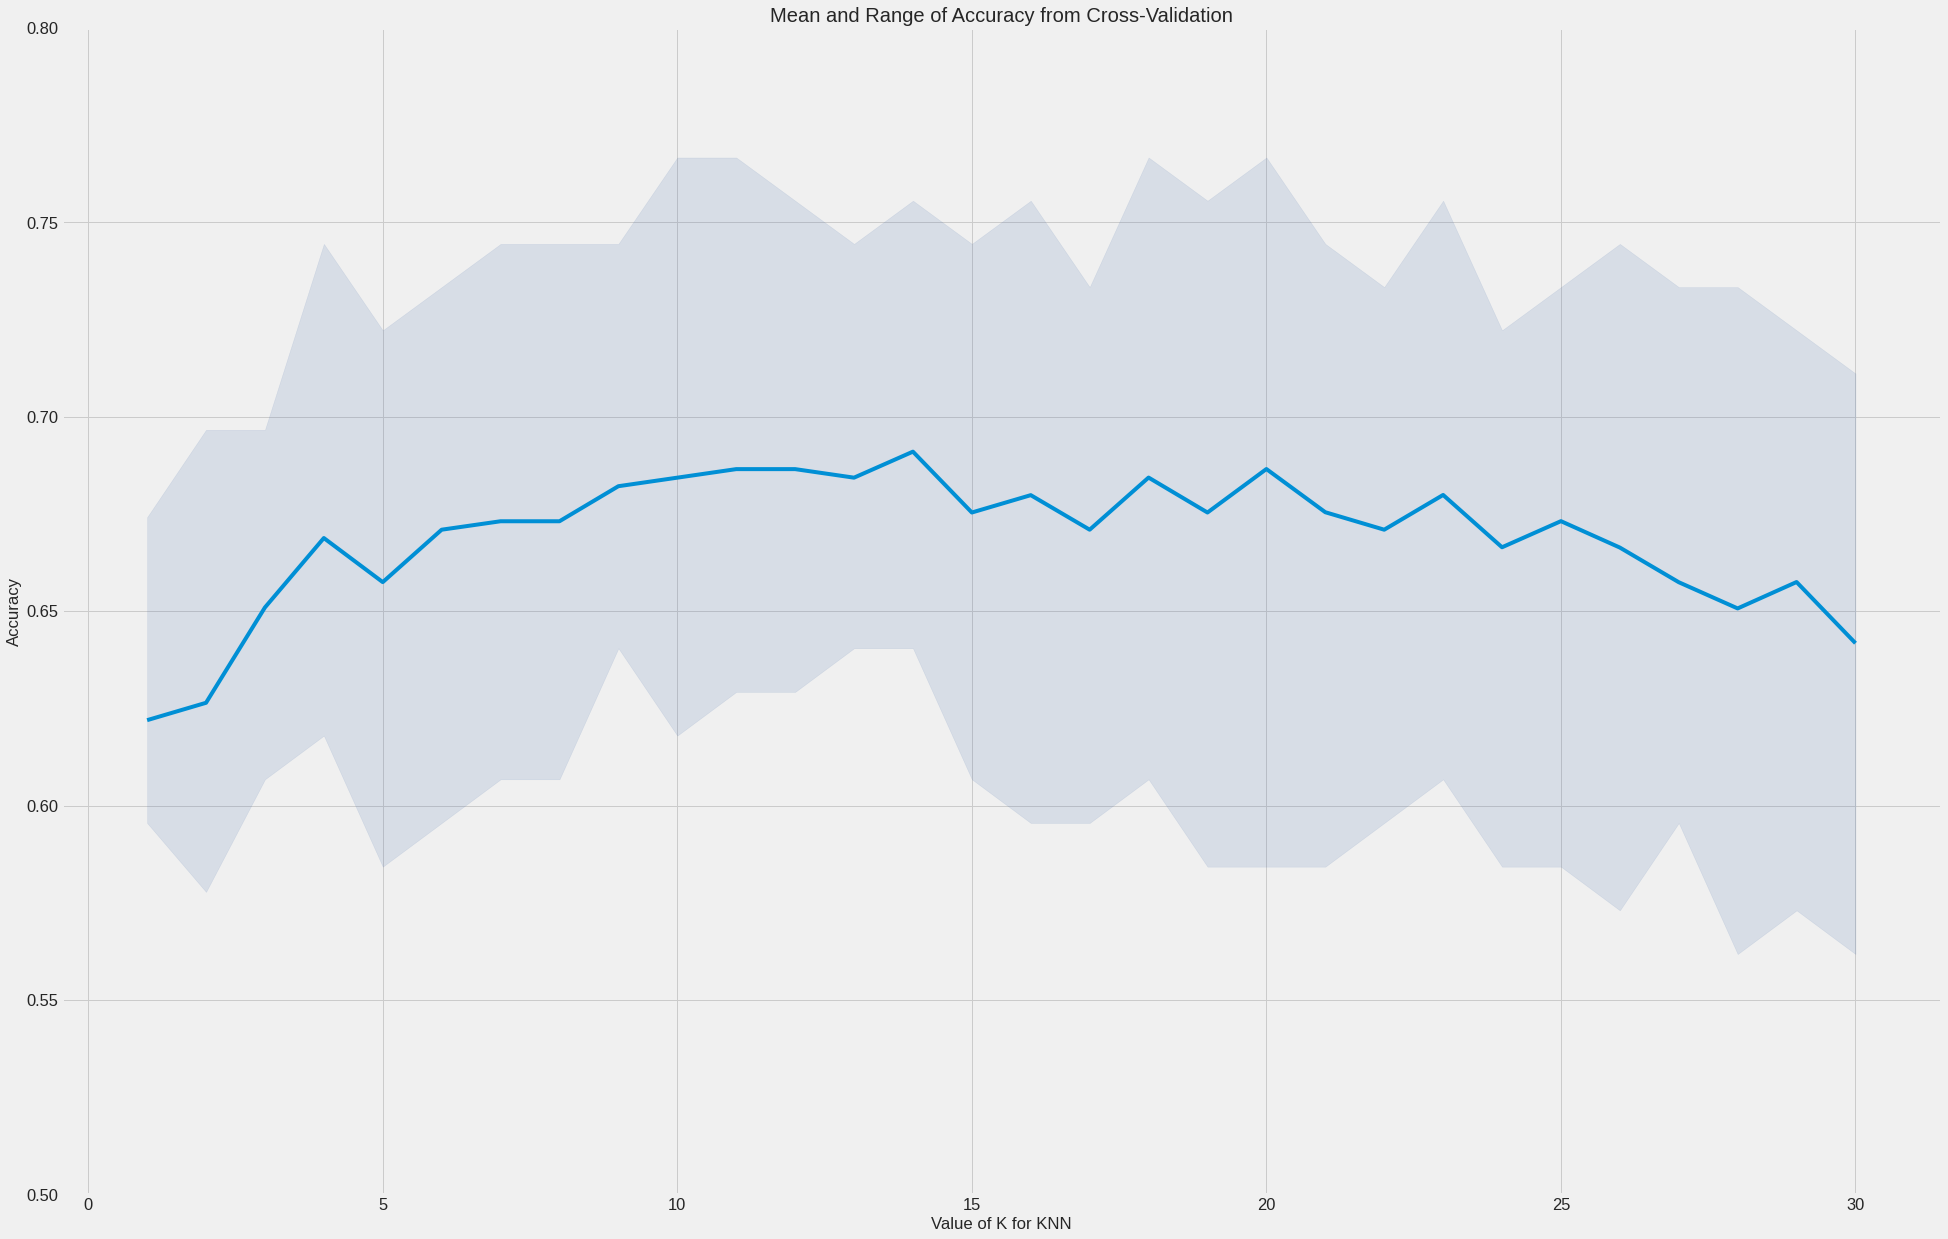

In [ ]:
fig, ax = plt.subplots()
ax.plot(k_range, k_scores)
ax.fill_between(
    k_range, k_min, k_max, color='b', alpha=.15)
ax.set_ylim(ymin=.5, ymax=.8)
plt.xlabel('Value of K for KNN')
plt.ylabel('Accuracy')
plt.title('Mean and Range of Accuracy from Cross-Validation')

### Cross-validation for model selection
**Goal**: Compare the best KNN model with logistic regression

In [ ]:
# 5-fold cross-validation with the best KNN model
knn = KNeighborsClassifier(n_neighbors=19)
print(cross_val_score(knn, X_scale, y, cv=5, scoring='accuracy').mean())
print(cross_val_score(knn, X_scale, y, cv=5, scoring='accuracy').std())

0.6753558052434457
0.058866513566479706


In [ ]:
# 5-fold cross-validation with logistic regression
logreg = LogisticRegression()
print(cross_val_score(logreg, X_scale, y, cv=5, scoring='accuracy').mean())
print(cross_val_score(logreg, X_scale, y, cv=5, scoring='accuracy').std())

0.7045193508114858
0.044022559642795604


### Other options with cross-validation

**Repeated cross-validation**

Repeat cross-validation multiple times (with different random splits of the data) and average the results. This creates a more reliable estimate of out-of-sample performance by reducing the variance associated with a single trial of cross-validation

**Nested cross-validation**

When we use the same cross-validation process and dataset are used to both tune and select a model, it is likely to lead to overly optimistic estimates of performance. Nested cross validation is a method that can mitigate this problem. In this approach, the hyperparameter optimization procedure is nested under the model selection procedure. This is a bit difficult to explain quickly, so at the end of this notebook, I have included snippets from Peter Ramadge's machine learning course documents. It contains a good explanation of nested cross validation. This method may be a good fit for some contexts, especially when you only have access to a small dataset.



###Train-Validation-Test/Holdout Method
Progressively throughout this tutorial, we have moved closer and closer to best practices for evaluating models. However, there are still some cases, particularly for scientific papers, where we have remaining issues. Consider the case of the train/test method (with repeated model iteration) and in the cross-validation example where we use the method both for model parameter optimization, comparison between different ML models, and evaluation. If our goal is to deploy a model into a (low-risk) industry setting, this might be sufficient because after the model is deployed, we can evaluate it through additional online methods (e.g., A/B testing) or by re-calcluating our ML metrics again on data collected post deployment. By doing this, we have in effect created a new dataset for evaluation that is wholly independent from the data used to train the model since that data did not even exist when the model was built. In academic research contexts, the output is often static (e.g., in a paper published in a journal, which does not get updated). Thus, to generate an honest assessment of our model performance, we need to create a dataset that is *never used in the training process* on which to conduct the final performance evaluation. 

In the train-validation-test method, we separate out a portion of our data that we will not use at all for other steps in the evaluation process. We can then conduct all of the steps we have already discussed using the data that was not withheld for the final test set. For example, of the remaining data, we will split it again into a training and validation set (or into multiple training and validation sets within cross validation), performing all steps of our evaluation. In most cases, once we have selected our best ML algorithm and determined which parameters to use with that model, we then train the model again using those selections on all the data in both the training and validation sets. Then as the final step, we test our model on the test data we withheld at the beginning and did not touch again.



### Avoiding evaluation pitfalls

There are a number of pitfalls we want to avoid when evaluating machine learning models. We will touch briefly on some here, but I highly recommend both `scikit learn`'s [documentation on pitfalls](https://scikit-learn.org/stable/common_pitfalls.html) and Michael Lones' excellent, easy to understand [guide](https://arxiv.org/pdf/2108.02497.pdf), which I'll draw bits and pieces from below. Princeton recently held a [workshop on reproducibility](https://sites.google.com/princeton.edu/rep-workshop/) in science using machine learning, which also has great suggestions on how to improve your research.


**Leakage**:

> *Data leakage is a spurious relationship between the independent variables and the target variable that arises as an artifact of the data collection, sampling, or pre-processing strategy. Since the spurious relationship won’t be present in the distribution about which scientific claims are made, leakage usually leads to inflated estimates of model performance [Kapoor & Narayanan, 2022](https://arxiv.org/pdf/2207.07048.pdf)*

A commonly told cautionary tale about leakage:

> *Tomaso Poggio⁠, the director of M.I.T.’s Center for Brains, Minds and Machines, offered a classic parable used to illustrate this disconnect. The Army trained a program to differentiate American tanks from Russian tanks with 100% accuracy. Only later did analysts realized that the American tanks had been photographed on a sunny day and the Russian tanks had been photographed on a cloudy day. The computer had learned to detect brightness ([Murphy, 2017](https://www.nytimes.com/2017/10/09/science/stanford-sexual-orientation-study.html))*

![title](dalle-tanks.png)

<div style="text-align: right"> 
    Bizzare tanks care of DALL-E https://labs.openai.com/
</div>


Despite being widely referenced, there has been [debate](https://www.gwern.net/Tanks) about whether this actually ever happened or even could happen. Still, the urban legend offers an easy to understand example of data leakage--if there is an artifact in the data collection process that is confounded with the outcome/target/response variable, estimates of model accuracy will be inflated compared to a real-world scenario where the confound is not present.

Think about this as being similar to experimental design. As much as possible, we want to minimize any differences between our treatment and control groups to ensure that our results have internal validity (and ideally, external validity).

**Don't look at ALL of your data**
A common piece of advice when developing machine learning models is to explore and visualize aspects of your dataset before doing anything else. This advice is generally helpful for informing the choices you make later about your model (e.g., featurization, imputation, etc.), but can also be a source of leakage. If you do exploratory analyses on **all** of your data, you have essentially gained information into your test data that could bias your model in ways that artificially inflate performanc estimates.

**Don't do feature selection on ALL your data**
There can be a lot of preprocessing steps in the machine learning process. In fact, these steps may constitute the bulk of your effort. Taking care (and leveraging subject matter expertise) in your preprocessing steps can dramatically improve your model performance, but sometimes these steps dramatically improve your model performance artificially. One way this can happen is if you select features or make choices about how to encode features using all your data. If you do this, implicit information about your test set will have leaked into your data before you even start training a model. Therefore, you should always make sure you set aside an appropriate holdout set **before** performing feature selection.

**Don't do data augmentation on ALL your data**
Like featurization and data exploration, augmentation procedures can be a source of leakage. For example, sometimes it makes sense to impute (i.e., fill in) null values where they exist in your dataset. If the strategy you use to determine which values to impute is based on all your data, this can be a source of leakage. For example, you might choose to impute null values in a feature based on that feature's mean. When you determine the mean, it should be based **only** on your training data. Then you can use the mean of the training data to impute the value in your test data. A similar approach also goes for the generation of synthetic data. Sometimes when data has severe class imbalance, techniques that generate synthetic data points that emulate the real data can be useful (e.g., [SMOTE](https://learn.microsoft.com/en-us/azure/machine-learning/component-reference/smote)). But, synthetic data should be developed to resemble the **training data only** not the entire dataset.

**Do report multiple metrics**
It's a good idea to report multiple metrics to allow the reader to better understand how your model performed. As one example we have already touched on, if your data has a class imbalance, accuracy alone is not an adequate measure of the model's performance. You will also need to include metrics that are less sensitive to class
imbalances. Along similar lines, be very transparent about which metrics you are reporting. For example, if you provide an estimate of area under the curve (AUC) be clear about whether this AUC is from an ROC curve or a precision-recall curve.

### Nested Cross Validation

Earlier I mentioned that nested cross validation is a process that can overcome biases in non-nested cross validation that inflate performance estimates. We can use the k-fold method in the diagram below for hyperparameter selection, model training, and model testing. The steps to nested cross validation are as follows:

* Partition the entire training dataset into k balanced folds. Then use an outer loop to evaluate classifier performance for a given hyperparameter value. The outer loop iterates through the k folds by training on k − 1 folds, and testing on the corresponding left-out fold. This approach results in k estimates of model performance. This is the outer loop. If this doesn't make sense yet, read the rest of the procedure for the inner loops and come back. It makes more sense when you understand what else is going on.


* Inside the outer loop, we place two inner loops. At the start of each of the above k iterations, we place a selection loop that iterates through a designated set of hyperparameter values. For each value, we train and evaluate the resulting classifier. 


* Here is where we use a third innermost loop. The simplest way to implement this inner loop is to use k − 2 of the k − 1 current training folds as the training subset and the left-aside fold of the present training folds as the validation subset. After the inner loop, we obtain k − 1 estimates of performance, yielding an assessment of the average performance of the current model and the spread of its performance about the average. 


* After training and evaluating each hyperparameter value, we select the “best” value. We can then train the model using the selected value on all of the k − 1 folds of the current training data. Then report its performance on the left-out test fold. At the end of the k iterations in the outer loop, we have k best hyperparameter value selections and k sets of performance metrics. 

This scheme is both complex and computationally expensive. However, it is appealing when training data is in short supply.

![title](nested-cross-validation.png)

<font size="1">

**Notes on source material**
    
* Much of this workshop notebook draws heavily from [this notebook](https://github.com/justmarkham/DAT8/blob/master/notebooks/09_model_evaluation.ipynb) because it contains a great explaination of evaluation paradigms. Some material was also adapted from maykulkarni's machine learning notebooks [repo](https://github.com/maykulkarni), and other parts were (lightly) adapted from [this tutorial](https://stackabuse.com/k-nearest-neighbors-algorithm-in-python-and-scikit-learn/). Parts of the cross-validation section are adapted from [this notebook](https://github.com/justmarkham/DAT8/blob/master/notebooks/13_cross_validation.ipynb) 
    
* The rad decision boundariy plot was adapted from [this post](https://www.tvhahn.com/posts/beautiful-plots-decision-boundary/)

* The NBA data for the KNN example was generated using the [basketball reference scraper repo](https://github.com/vishaalagartha/basketball_reference_scraper) to scrape NBA statistics from the website https://www.basketball-reference.com. Source data extracted using this repo were transformed into their current format by adapting code from [this tutorial](https://towardsdatascience.com/simple-modeling-of-nba-positions-using-the-k-nearest-neighbors-machine-learning-algorithm-223b8addb08f) on KNN. You can access my complete code for generating the data [here](https://github.com/amywinecoff/baskeball-scraper/blob/main/get_basketball_data.ipynb). I apologize in advance for the chaos of this repo.
    
* As noted before, the section on nested cross validation is lifted with little adaptation from Peter Ramadge's Machine Learning and Pattern Recognition. 
    
* The pitfalls section draws from Michael Lones'[guide](https://arxiv.org/pdf/2108.02497.pdf).
</font> 